### Pinchout Example
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases how with one parameter (Z_controlpoint), multiple structural models can be generated for a pinched out layer at an unconformity using a 3D synthetic example. Corresponding flow models are automatically generated and run due to the seamless workflow. Results show significantly different head distributions for eack structural model.

### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [18]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference

P.xypumpbores = [] 
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (2500, 2500), (5000,5000)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

obs_z = [-40, -50, -100, -200, -300]
P.nzobs = len(obs_z)

P.zobs = np.ones((P.nobs, P.nzobs))
for j in range(P.nzobs):
    P.zobs[:, j] = P.zobs[:, j] * obs_z[j] 

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100       # Interior boundary
P.boundmaxtri = 50000 # 8/5 - was 20000
P.modelmaxtri = 50000 # 8/5 - was 30000
P.angle = 32   # minimum triangle angles
P.nlv  = 30    

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 99999

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable

P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = False

P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)

### Pinchouts - multiple simulations

In [19]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

In [21]:
options = np.linspace(-250, 0, 6) # control point z values

pinchout_modelnames, pinchout_models, pinchout_obs_heads = [],[],[]        
heads = []

for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    pinchout_obs_heads.append((process_obs_steady(P, M)))
    heads.append((M.head_ss))
    f = os.path.join(vtk_workspace, "pinchouts", M.modelname)
    M.gwf.export(f, fmt="vtk")

C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-250.0  ...
Time taken =  1.680435
Creating property arrays for  PO_-250.0  ...
Time taken =  0.01015
Adding flow packages to  PO_-250.0  ...
Time taken =  0.573486
Writing simulation and gwf for  PO_-250.0  ...
PO_-250.0
Running simulation for  PO_-250.0  ...
Period =  Steady 
Model success =  True
run_time =  7.997483


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-200.0  ...
Time taken =  1.6907
Creating property arrays for  PO_-200.0  ...
Time taken =  0.002124
Adding flow packages to  PO_-200.0  ...
Time taken =  0.582433
Writing simulation and gwf for  PO_-200.0  ...
PO_-200.0
Running simulation for  PO_-200.0  ...
Period =  Steady 
Model success =  True
run_time =  6.942229


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-150.0  ...
Time taken =  1.927186
Creating property arrays for  PO_-150.0  ...
Time taken =  0.006997
Adding flow packages to  PO_-150.0  ...
Time taken =  0.802341
Writing simulation and gwf for  PO_-150.0  ...
PO_-150.0
Running simulation for  PO_-150.0  ...
Period =  Steady 
Model success =  True
run_time =  6.655241


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-100.0  ...
Time taken =  1.752077
Creating property arrays for  PO_-100.0  ...
Time taken =  0.015672
Adding flow packages to  PO_-100.0  ...
Time taken =  0.629504
Writing simulation and gwf for  PO_-100.0  ...
PO_-100.0
Running simulation for  PO_-100.0  ...
Period =  Steady 
Model success =  True
run_time =  5.977928


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-50.0  ...
Time taken =  1.814889
Creating property arrays for  PO_-50.0  ...
Time taken =  0.010079
Adding flow packages to  PO_-50.0  ...
Time taken =  0.681187
Writing simulation and gwf for  PO_-50.0  ...
PO_-50.0
Running simulation for  PO_-50.0  ...
Period =  Steady 
Model success =  True
run_time =  6.170268


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_0.0  ...
Time taken =  1.733543
Creating property arrays for  PO_0.0  ...
Time taken =  0.00806
Adding flow packages to  PO_0.0  ...
Time taken =  0.59764
Writing simulation and gwf for  PO_0.0  ...
PO_0.0
Running simulation for  PO_0.0  ...
Period =  Steady 
Model success =  True
run_time =  5.584822


In [22]:
M.obslist

[['OB1_-40.0', 'head', 2259],
 ['OB1_-50.0', 'head', 2259],
 ['OB1_-100.0', 'head', 3172],
 ['OB1_-200.0', 'head', 3578],
 ['OB1_-300.0', 'head', 4404],
 ['OB2_-40.0', 'head', 2260],
 ['OB2_-50.0', 'head', 2260],
 ['OB2_-100.0', 'head', 6052],
 ['OB2_-200.0', 'head', 6052],
 ['OB2_-300.0', 'head', 7078],
 ['OB3_-40.0', 'head', 2261],
 ['OB3_-50.0', 'head', 2261],
 ['OB3_-100.0', 'head', 3579],
 ['OB3_-200.0', 'head', 4921],
 ['OB3_-300.0', 'head', 6053],
 ['OB4_-40.0', 'head', 2262],
 ['OB4_-50.0', 'head', 2262],
 ['OB4_-100.0', 'head', 6054],
 ['OB4_-200.0', 'head', 6054],
 ['OB4_-300.0', 'head', 7080]]

In [23]:
heads_A = find_watertable_disu(P, M = pinchout_models[-1], layer = 2)
heads_B = find_watertable_disu(P, M = pinchout_models[0], layer = 2)

C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\398711091.py:6: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


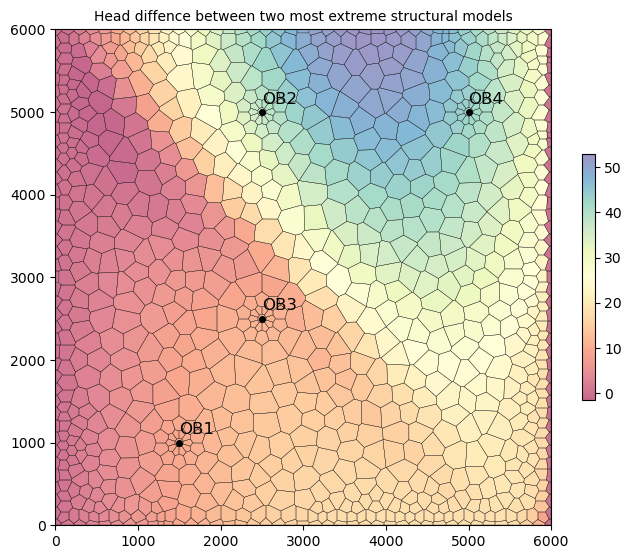

In [24]:
plot_head_diff(P, pinchout_models[0], heads_A, heads_B)

C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\449695775.py:13: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


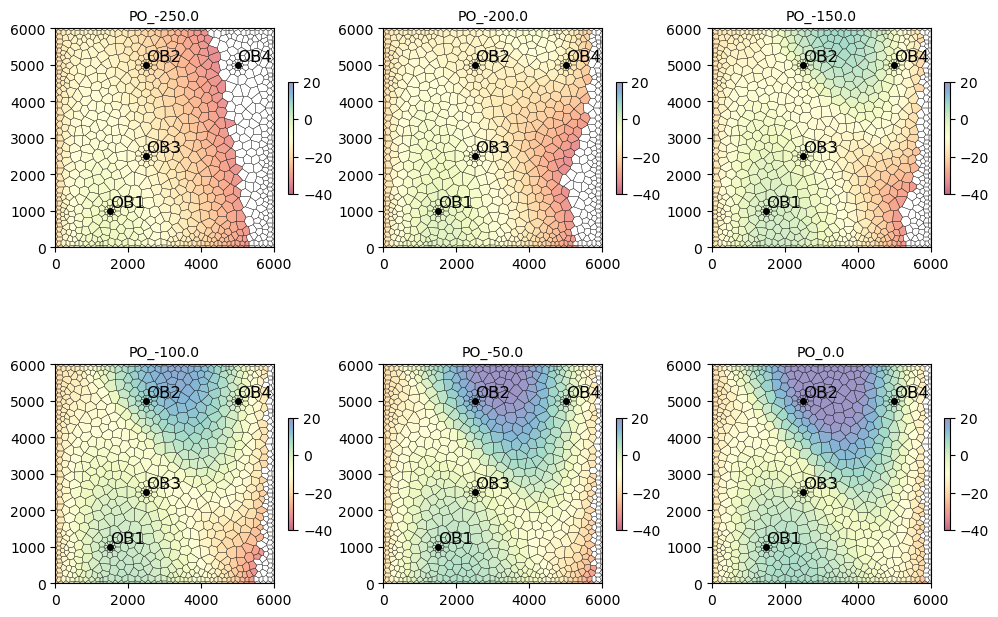

In [25]:
plot_bylayer(P, models = pinchout_models, layer = 1, vmin = -40, vmax = 20) 

In [33]:
P.zobs

array([[ -40.,  -50., -100., -200., -300.],
       [ -40.,  -50., -100., -200., -300.],
       [ -40.,  -50., -100., -200., -300.],
       [ -40.,  -50., -100., -200., -300.]])

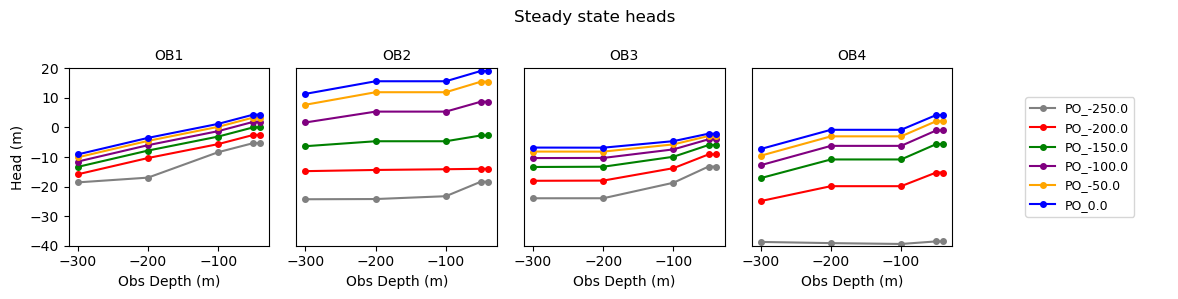

In [35]:
# Plot multiple sims
plot_observations(ylim = [-40, 20], modelnames = pinchout_modelnames, heads = pinchout_obs_heads)

In [27]:
m = pinchout_models[0]
m.lith.max()


3.0

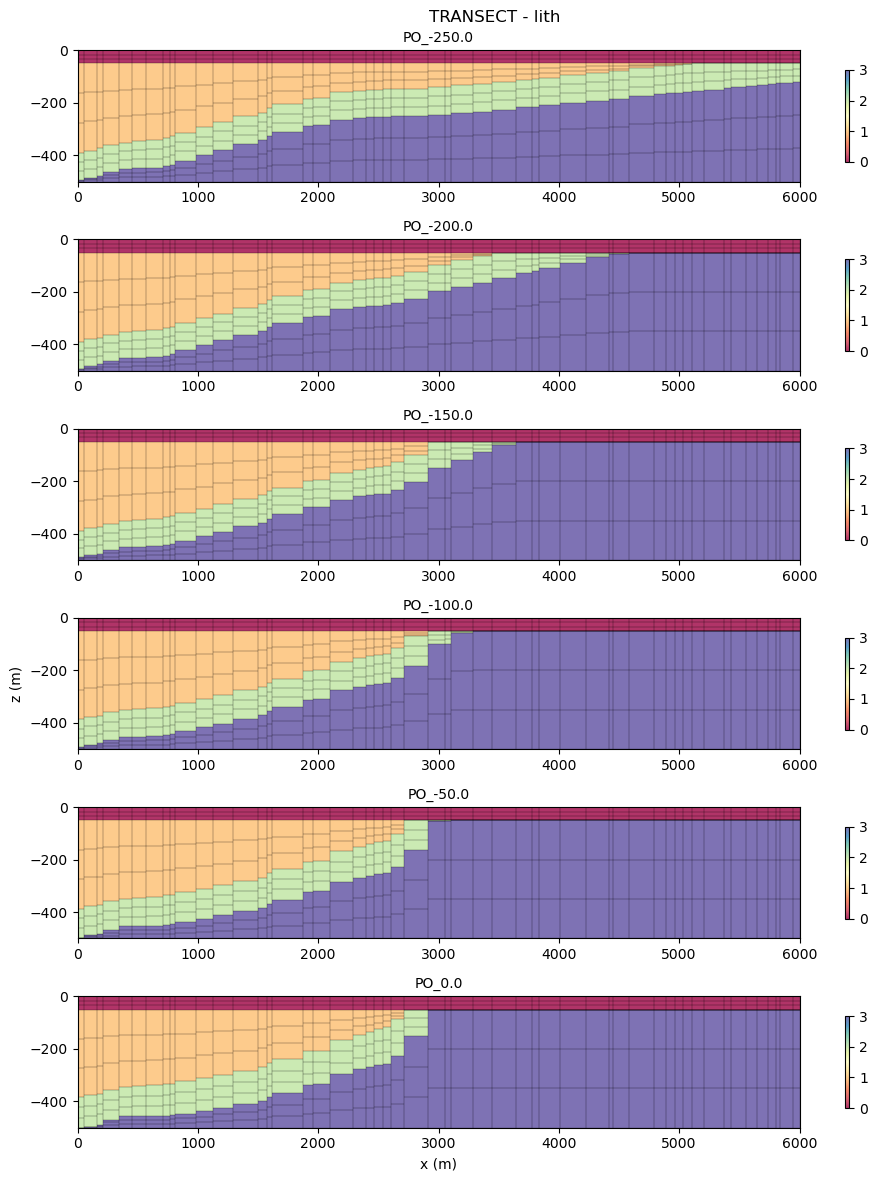

In [28]:
multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

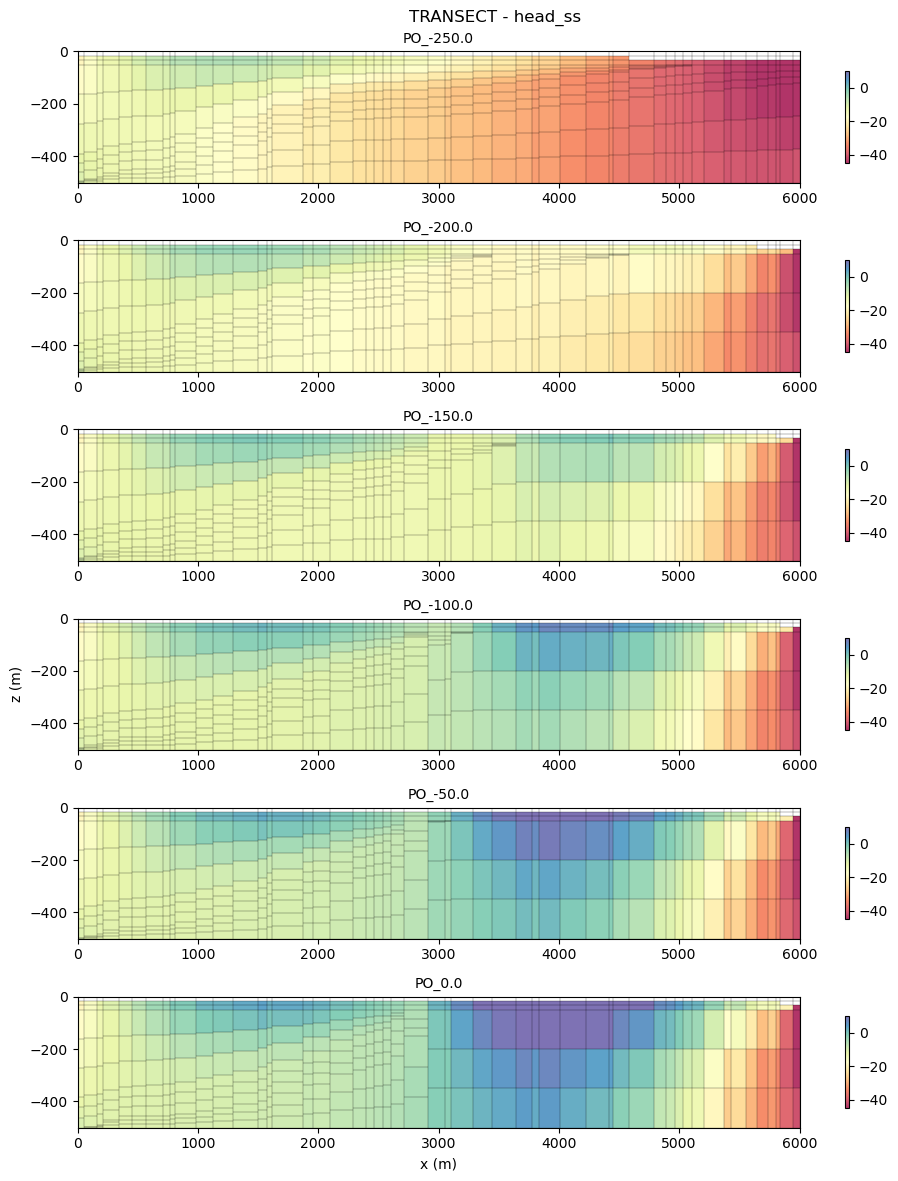

In [29]:
multiplot_prop_transect(P, models = pinchout_models, array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 10)

In [30]:
P1_L = (500**2 + 500**2)**0.5
P2_L = (2500**2 + 2500**2)**0.5
CP1_L = (3000**2 + 3000**2)**0.5

In [31]:
M = pinchout_models[0]
M.botm.shape
M.vgrid
gi = flopy.utils.GridIntersect(M.vgrid)
point = Point(P1_L, P1_L)
cell = np.array(list(gi.intersect(point)["cellids"]))
P1_z1 = M.gwf.disu.bot[cell]

C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\3095586362.py:81: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:
C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\3095586362.py:81: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:
C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\3095586362.py:81: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:
C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\3095586362.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\19904604\AppData\Local\Temp\ipykernel_11860\3095586362.py:113: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


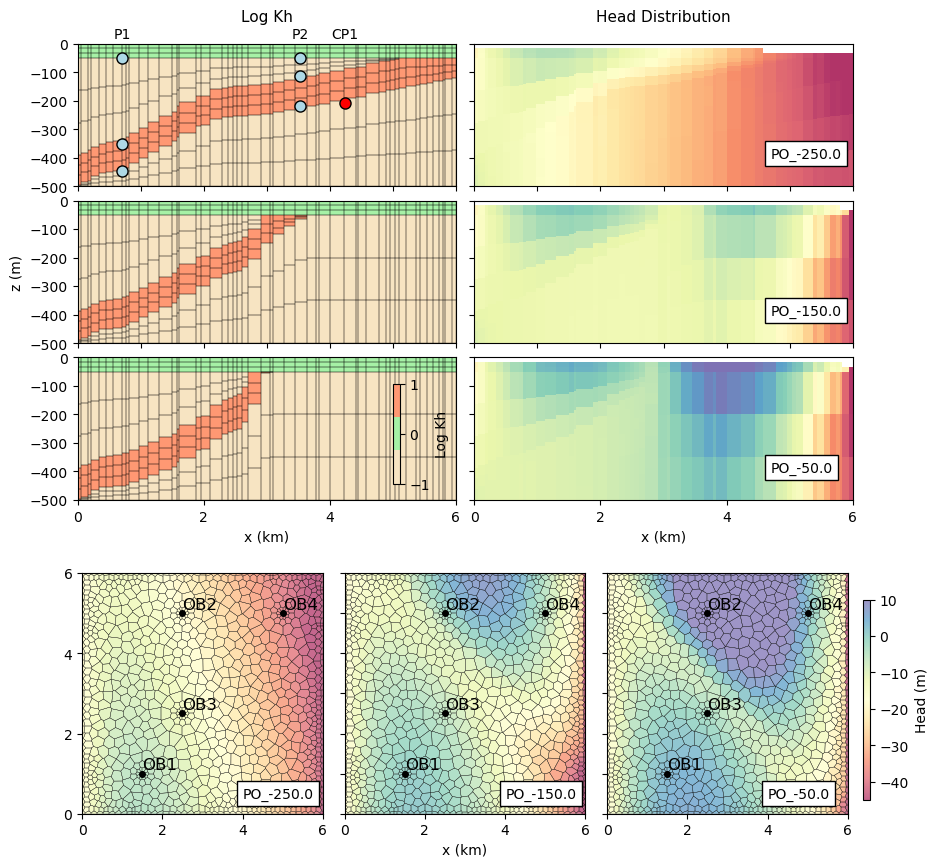

In [45]:
#%run ./figures_paper.ipynb
def figure3(P, models, X0, Y0, X1, Y1, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    
    c = mpl.colors.ListedColormap(['wheat', 'lightgreen', 'coral'])
    n = mpl.colors.Normalize(vmin=-1,vmax=1)
    
    fig = plt.figure(figsize = (10,10))
    #fig.suptitle("TRANSECT - " + array)
    nm = [0,2,4]
    for i in nm:
        ax = plt.subplot(5, 2, i+1)
        M = models[i]
        model = M.gwf
        a = getattr(M, 'k11')
        xsect = flopy.plot.PlotCrossSection(model=model, line={"line": [(X0, Y0),(X1, Y1)]}, 
                                            extent = [P.x0,P.x1,P.z0,P.z1], geographic_coords=True)
        csa = xsect.plot_array(a = logfunc(a), cmap=c, norm=n, alpha=0.8, vmin = vmin, vmax = vmax)
        ax.set_ylim([-500, 0])
        
        linecollection = xsect.plot_grid(lw = 0.2, color = 'black') # Don't plot grid for reference
        #plt.colorbar(csa, shrink = 0.7)
        
        cb_ax = fig.add_axes([.44,.44,.007,0.1])
        fig.colorbar(csa,orientation='vertical',cax=cb_ax, label='Log Kh')
        
        
        if i == 0:
            ax.set_title('Log Kh', y=1.1, size = 11)
            ax.plot(P1_L, -50, color='black', marker='o', markerfacecolor='lightblue', markersize=8)
            ax.plot(P1_L, -350, color='black', marker='o', markerfacecolor='lightblue', markersize=8)
            ax.plot(P1_L, -445, color='black', marker='o', markerfacecolor='lightblue', markersize=8)
            ax.plot(P2_L, -50, color='black', marker='o', markerfacecolor='lightblue', markersize=8)
            ax.plot(P2_L, -113, color='black', marker='o', markerfacecolor='lightblue', markersize=8)
            ax.plot(P2_L, -220, color='black', marker='o', markerfacecolor='lightblue', markersize=8)
            ax.plot(CP1_L, -207, color='black', marker='o', markerfacecolor='red', markersize=8)
            ax.annotate("P1",(P1_L, 20), size = 10, ha = 'center', annotation_clip = False)
            ax.annotate("P2",(P2_L, 20), size = 10, ha = 'center', annotation_clip = False)
            ax.annotate("CP1",(CP1_L, 20), size = 10, ha = 'center', annotation_clip = False)
        if i == 0:
            ax.set(xticklabels=[])
        if i == 2:
            ax.set_ylabel('z (m)', size = 10)
            ax.set(xticklabels=[])
        if i == 4: 
            ax.set_xlabel('x (km)', size = 10)
            ax.set_xticks([0, 2000, 4000, 6000])
            ax.set_xticklabels([0, 2, 4, 6])
        
    for i in nm:
        ax = plt.subplot(5, 2, i+2)
        M = models[i]
        model = M.gwf
        a = getattr(M, 'head_ss')
        xsect = flopy.plot.PlotCrossSection(model=model, line={"line": [(X0, Y0),(X1, Y1)]}, 
                                            extent = [P.x0,P.x1,P.z0,P.z1], geographic_coords=True)
        csa = xsect.plot_array(a = a, cmap='Spectral', alpha=0.8, vmin = -45, vmax = 10)
        ax.set_ylim([-500, 0])
        ax.annotate(M.modelname, (4700, -400), size = 10, bbox=dict(facecolor = 'white'))
        if i == 0:
            ax.set(xticklabels=[])
            ax.set(yticklabels=[])
            ax.set_title('Head Distribution', y = 1.1, size = 11)
        if i == 2:
            ax.set(xticklabels=[])
            ax.set(yticklabels=[])
        if i == 4: 
            ax.set_xlabel('x (km)', size = 10)
            ax.set_xticks([0, 2000, 4000, 6000])
            ax.set_xticklabels([0, 2, 4, 6])
            ax.set(yticklabels=[])
        #plt.colorbar(csa, shrink = 0.7)
        
    for i in nm:
        layer = 2
        ax = plt.subplot(3, 3, int(i/2 + 7))
        M = models[i]
        model = M.gwf
        water_table = flopy.utils.postprocessing.get_water_table(M.gwf.output.head().get_data())
        M.heads_disv = -1e30 * np.ones_like(M.idomain, dtype=float) 
        for k, h in enumerate(water_table):
            if math.isnan(h) == False: 
                M.heads_disv[M.cellid_disu==k] = h        
        pmv = flopy.plot.PlotMapView(modelgrid=M.vgrid)
        H = pmv.plot_array(M.heads_disv[layer], vmin = -45, vmax = 10, cmap = 'Spectral', alpha = 0.6)
        for j in range(len(P.xyobsbores)):
            ax.plot(P.xyobsbores[j][0], P.xyobsbores[j][1],'o', ms = '4', c = 'black')
            ax.annotate(P.idobsbores[j], (P.xyobsbores[j][0], P.xyobsbores[j][1]+100), c='black', size = 12) #, weight = 'bold')
        
        for j in range(len(P.xypumpbores)):
            ax.plot(P.xypumpbores[j][0], P.xypumpbores[j][1],'o', ms = '4', c = 'red')
            ax.annotate(P.idpumpbores[j], (P.xypumpbores[j][0], P.xypumpbores[j][1]+100), c='red', size = 12) #, weight = 'bold')
            
        if M.plan == 'car': P.sg.plot(ax=ax, edgecolor='black', lw = 0.2)
        if M.plan == 'tri': P.tri.plot(ax=ax, edgecolor='black', lw = 0.2)
        if M.plan == 'vor': P.vor.plot(ax=ax, edgecolor='black', lw = 0.2)
        if i == 2: ax.set_yticklabels([])
        if i == 2: ax.set_xlabel('x (km)', size = 10)
        if i == 4: ax.set(yticklabels=[])
        if i == 0:
            ax.set_yticks([0, 2000, 4000, 6000])
            ax.set_yticklabels([0, 2, 4, 6])
        
        ax.set_title(' ') 
        ax.set_xticks([0, 2000, 4000, 6000])
        ax.set_xticklabels([0, 2, 4, 6])
        #plt.colorbar(H, shrink = 0.7)
        ax.annotate(M.modelname, (4000, 400), size = 10, bbox=dict(facecolor = 'white'))
    cb_ax = fig.add_axes([.91,.124,.007,0.2])
    fig.colorbar(H,orientation='vertical',cax=cb_ax, label = 'Head (m)')


    plt.subplots_adjust(wspace=0.05, hspace=0.1)    
    plt.tight_layout()  
    plt.show()   
    fig.savefig('../figures/fig3.tif', dpi=300)

figure3(P, models = pinchout_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)